# <span style='color:red;'> 02 Simulation of synthetic time series data</span>

<span style="color:red;">This notebook is currently under construction, the plan is to have codes to simulate synthetic data here.</span>

In this notebook, we aim to synthesise some *simple* time series data using the telegraph model, with two different labels e.g., normal and stressful conditions for the cells. The signals need to be produced as similarly to each other as much as possible so that it ressembles microfluidic time series data, and are harder for the ML algorithm to classify.

In [ ]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import pandas as pd
import os
import scipy.stats as st
import numba
import biocircuits
import itertools

# Define the update matrix for the reactions
# Columns: G, G*, M
# Columns: G, G*, M
update_matrix = np.array([
    [-1, 1, 0],   # G -> G* (Gene activation)
    [1, -1, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1],    # G -> G + M (mRNA production)
    [0, 0, -1],   # M -> 0 (mRNA degradation)
], dtype=int)

def telegraph_model_propensity(propensities, population, t, sigma_u, sigma_b, rho, d):
    """
    Updates the propensities for the telegraph model reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M]
        t: Time (not used but required by signature)
        sigma_u: Rate of G -> G* (deactivation)
        sigma_b: Rate of G* -> G (activation)
        rho: Rate of G -> G + M (mRNA production)
        d: Rate of M -> 0 (mRNA degradation)
    """
    # Unpack population
    G, G_star, M = population
    
    # Update propensities for each reaction
    propensities[0] = sigma_u * G          # G -> G*
    propensities[1] = sigma_b * G_star     # G* -> G
    propensities[2] = rho * G              # G -> G + M
    propensities[3] = d * M                # M -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

# Worker function must be at the top level to be picklable

def run_simulation(args):
    """
    Runs a single simulation for a given parameter set.
    """
    param_set, time_points, size = args
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]

    # Save each trajectory as a row with label
    return [[label] + list(trajectory) for trajectory in samples]

def simulate_two_telegraph_model_systems(parameter_sets, time_points, size):
    """
    Simulates two systems using stochastic gene expression model.
    
    Parameters:
        parameter_sets (list): List of parameter dictionaries for each system.
        time_points (numpy array): Array of time points for the simulation.
        size (int): Number of simulations per condition.
    
    Returns:
        pd.DataFrame: DataFrame containing simulation results.
    """
    num_cores = multiprocessing.cpu_count()
    with multiprocessing.Pool(num_cores) as pool:
        print(f"Running simulations on {num_cores} cores..."
              f"\nSystem 1 parameters: {parameter_sets[0]}"
              f"\nSystem 2 parameters: {parameter_sets[1]}") 
        results = list(tqdm.tqdm(pool.imap(run_simulation, [(p, time_points, size) for p in parameter_sets]), 
                                 total=len(parameter_sets), desc="Simulating Systems"))

    # Flatten results
    results = [item for sublist in results for item in sublist]

    # Convert to DataFrame
    columns = ["label"] + [f"time_{t}" for t in time_points]
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

import numpy as np
import matplotlib.pyplot as plt

################## Reports and Statistical Analysis
def find_steady_state(time_points, mean_trajectory, threshold=0.05):
    """
    Determine the time point when the system reaches steady state.
    
    Parameters:
        time_points (numpy array): Array of time points.
        mean_trajectory (numpy array): Mean mRNA counts over time.
        threshold (float): Relative change threshold for steady state detection.
        
    Returns:
        steady_state_time (float): Time when steady state is reached.
        steady_state_index (int): Index corresponding to the steady state time.
    """
    window_size = 5  # Look at changes over a small window
    for i in range(len(mean_trajectory) - window_size):
        recent_change = np.abs(np.diff(mean_trajectory[i:i + window_size])).mean()
        if recent_change < threshold * mean_trajectory[i]:  
            return time_points[i], i
    return time_points[-1], len(time_points) - 1  # Default to last time point if no steady state detected

def statistical_report(time_points, stress_trajectories, normal_trajectories):
    """
    Generate a statistical report for the simulated systems, including mean and variance at steady state.

    Parameters:
        time_points (numpy array): Array of time points for the simulation.
        stress_trajectories (numpy array): Array of mRNA trajectories for stressed condition.
        normal_trajectories (numpy array): Array of mRNA trajectories for normal condition.
    """
    # Compute mean trajectories
    mean_stress = stress_trajectories.mean(axis=0)
    mean_normal = normal_trajectories.mean(axis=0)

    # Find steady-state time points
    ss_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
    ss_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)

    # Check if steady state is reached, logic: index is less than the total length of time points
    ss_reached_stress = ss_index_stress < len(time_points) - 1
    ss_reached_normal = ss_index_normal < len(time_points) - 1

    # Extract steady-state portions
    stress_ss_data = stress_trajectories[:, ss_index_stress:]
    normal_ss_data = normal_trajectories[:, ss_index_normal:]

    # Compute mean and variance after steady state
    mean_mRNA_stress_ss = stress_ss_data[ss_index_stress:].mean()
    var_mRNA_stress_ss = stress_ss_data[ss_index_stress:].var()

    mean_mRNA_normal_ss = normal_ss_data[ss_index_normal:].mean()
    var_mRNA_normal_ss = normal_ss_data[ss_index_normal:].var()

    # Print Report
    print("\n=== Statistical Report ===")
    print(f"Steady-State Reached: {'Yes' if ss_reached_stress else 'No'} (Stress) | {'Yes' if ss_reached_normal else 'No'} (Normal)")

    if not ss_reached_stress:
        print("⚠️ Warning: Steady-state not clearly reached in stressed condition. Consider extending simulation time.")

    if not ss_reached_normal:
        print("⚠️ Warning: Steady-state not clearly reached in normal condition. Consider extending simulation time.")

    print("\n📊 **Steady-State Statistics:**")
    print(f"  Stressed Condition (after {ss_time_stress:.1f} min):")
    print(f"    - Mean mRNA Count: {mean_mRNA_stress_ss:.2f}")
    print(f"    - Variance: {var_mRNA_stress_ss:.2f}")

    print(f"\n  Normal Condition (after {ss_time_normal:.1f} min):")
    print(f"    - Mean mRNA Count: {mean_mRNA_normal_ss:.2f}")
    print(f"    - Variance: {var_mRNA_normal_ss:.2f}")

    return {
        "Steady State Reached": {"Stress": ss_reached_stress, "Normal": ss_reached_normal},
        "Stress Stats": {"Mean": mean_mRNA_stress_ss, "Variance": var_mRNA_stress_ss, "Steady State Time": ss_time_stress},
        "Normal Stats": {"Mean": mean_mRNA_normal_ss, "Variance": var_mRNA_normal_ss, "Steady State Time": ss_time_normal}
    }

# Example usage:
# report = statistical_report(time_points, stress_trajectories, normal_trajectories)

################## Mean mRNA counts over time
def plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories):
    """
    Plot mRNA trajectories for each condition and determine steady-state behavior.
    
    Parameters:
        time_points (numpy array): Array of time points for the simulation.
        stress_trajectories (numpy array): Array of mRNA trajectories for stressed condition.
        normal_trajectories (numpy array): Array of mRNA trajectories for normal condition.
    """
    # Compute mean trajectories
    mean_stress = stress_trajectories.mean(axis=0)
    mean_normal = normal_trajectories.mean(axis=0)

    # Find steady-state time points
    steady_state_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
    steady_state_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)

    # # Compute steady-state means
    # mean_mRNA_stress_ss = mean_stress[ss_index_stress:].mean()
    # mean_mRNA_normal_ss = mean_normal[ss_index_normal:].mean()

    # Plot mRNA trajectories
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot mean trajectory for each condition
    ax.plot(time_points, mean_stress, color='blue', label='Stressed Condition (Mean)', linewidth=2)
    ax.plot(time_points, mean_normal, color='green', label='Normal Condition (Mean)', linewidth=2)

    # Mark steady-state time
    ax.axvline(steady_state_time_stress, color='blue', linestyle='--', label=f"Steady-State (Stress) @ {steady_state_time_stress:.1f}")
    ax.axvline(steady_state_time_normal, color='green', linestyle='--', label=f"Steady-State (Normal) @ {steady_state_time_normal:.1f}")

    # Labels and legend
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Count")
    ax.set_title(f"Yeast mRNA Trajectories Under Different Conditions (Mean for {stress_trajectories.shape[0]} cells)")
    ax.legend()
    ax.grid(True)

    # Show plot
    plt.show()

# Example usage:
# stress_trajectories and normal_trajectories should be your simulated mRNA trajectory arrays
# plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)

################## Variance of mRNA counts over time
def plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories):
    """
    Plot the variance of mRNA counts over time for each condition, ensuring variance is calculated after steady state.

    Parameters:
        time_points (numpy array): Array of time points for the simulation.
        stress_trajectories (numpy array): Array of mRNA trajectories for stressed condition.
        normal_trajectories (numpy array): Array of mRNA trajectories for normal condition.
    """
    # Find the time index at which steady state is reached
    ss_time_stress, ss_index_stress = find_steady_state(time_points, stress_trajectories.mean(axis=0))
    ss_time_normal, ss_index_normal = find_steady_state(time_points, normal_trajectories.mean(axis=0))

    # Extract steady-state portions
    stress_ss_data = stress_trajectories[:, ss_index_stress:]
    normal_ss_data = normal_trajectories[:, ss_index_normal:]

    # Compute mean and variance at steady state (same as statistical_report)
    stress_mean_ss = stress_ss_data.mean()
    normal_mean_ss = normal_ss_data.mean()
    
    stress_var_ss = stress_ss_data.var()
    normal_var_ss = normal_ss_data.var()

    # Compute variance over time for plotting
    stress_var_over_time = stress_trajectories.var(axis=0)
    normal_var_over_time = normal_trajectories.var(axis=0)

    # Plot the variance of the mRNA counts over time for each condition
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(time_points, stress_var_over_time, color='blue', label='Stressed Condition', linewidth=2)
    ax.plot(time_points, normal_var_over_time, color='green', label='Normal Condition', linewidth=2)

    # Mark steady-state time
    mean_stress = stress_trajectories.mean(axis=0)
    mean_normal = normal_trajectories.mean(axis=0)
    steady_state_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
    steady_state_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)
    ax.axvline(steady_state_time_stress, color='blue', linestyle='--', label=f"Steady-State (Stress) @ {steady_state_time_stress:.1f}")
    ax.axvline(steady_state_time_normal, color='green', linestyle='--', label=f"Steady-State (Normal) @ {steady_state_time_normal:.1f}")

    # Labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Variance of mRNA Count')
    ax.set_title('Variance of mRNA Counts Over Time')
    ax.legend()
    ax.grid(True)

    # Adjust y-axis limits
    ax.set_ylim([0, max(stress_var_over_time.max(), normal_var_over_time.max()) * 1.1])

    # Show plot
    plt.show()

    # Print variance at steady state (consistent with statistical_report)
    print("\n=== Variance at Steady State ===")
    print(f"  Stressed Condition (after {ss_time_stress:.1f} min): Mean = {stress_mean_ss:.2f}, Variance = {stress_var_ss:.2f}")
    print(f"  Normal Condition (after {ss_time_normal:.1f} min): Mean = {normal_mean_ss:.2f}, Variance = {normal_var_ss:.2f}")

    return {
        "Stress Variance at Steady State": stress_var_ss,
        "Normal Variance at Steady State": normal_var_ss,
        "Stress Mean at Steady State": stress_mean_ss,
        "Normal Mean at Steady State": normal_mean_ss,
        "Steady State Time": {"Stress": ss_time_stress, "Normal": ss_time_normal}
    }

# Example usage:
# variance_report = plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)

################## Distribution of mRNA counts at a specific time point

def plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories):
    """
    Plot the data distribution for each condition at a specific time point.
    
    Parameters:
        time_points (numpy array): Array of time points for the simulation.
        stress_trajectories (numpy array): Array of mRNA trajectories for stressed condition.
        normal_trajectories (numpy array): Array of mRNA trajectories for normal condition.
    """

    # steady-state time
    mean_stress = stress_trajectories.mean(axis=0)
    mean_normal = normal_trajectories.mean(axis=0)
    steady_state_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
    steady_state_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)

    # Extract mRNA counts after steady state is reached, for each condition
    stress_midpoint = stress_trajectories[:, ss_index_stress + 1]
    normal_midpoint = normal_trajectories[:, ss_index_normal + 1]

    # Plot the data distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(stress_midpoint, bins=10, alpha=0.5, label='Stressed Condition', color='blue')
    ax.hist(normal_midpoint, bins=10, alpha=0.5, label='Normal Condition', color='green')

    # Labels and legend
    ax.set_xlabel("mRNA Count at Steady-State Time Point")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of mRNA Counts at Steady-State Time Point")
    ax.legend()
    ax.grid(True)

    # Show plot
    plt.show()

## Simulate two different systems with the same mean so that the 2 time series are similar

**The telegraph model:**

$$
G^{\star} \xrightleftharpoons[\sigma_{\text{u}}]{\sigma_{\text{b}}} G \xrightarrow{\rho} G + M, \quad M \xrightarrow{d} \emptyset
$$

**System 1:** Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)

**System 2:** Stressed Condition (σ_u_stress = 18.0, σ_b_stress = 0.01)

- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer.
This combination will lead to lower mRNA levels.

**Theoretical foundation:**

The equation for the mean mRNA levels at steady state, in terms of the system parameters, is:

$$ \mu = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} $$

The equation for the mRNA level variance at steady state, in terms of the system parameters, is: 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

From these equations, we can fix the mean or variance to be the same by moving the terms around. Below is an example, to **fix the mean of the mRNA levels**. 

In [ ]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories_mean_fixed.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(time_points, stress_trajectories, normal_trajectories)

Visualise the time series generated - they should be quite similar

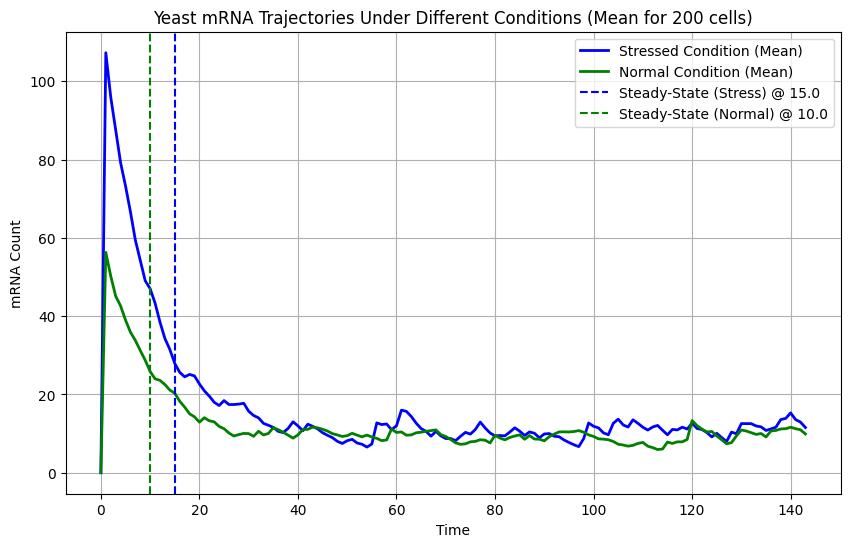

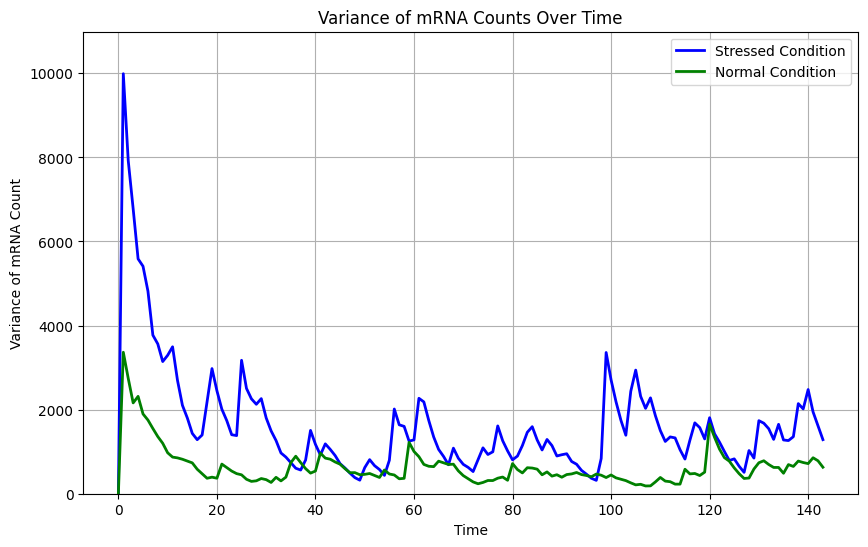


=== Variance at Steady State ===
  Stressed Condition (after 15.0 min): Mean = 12.07, Variance = 1345.70
  Normal Condition (after 10.0 min): Mean = 10.37, Variance = 559.07


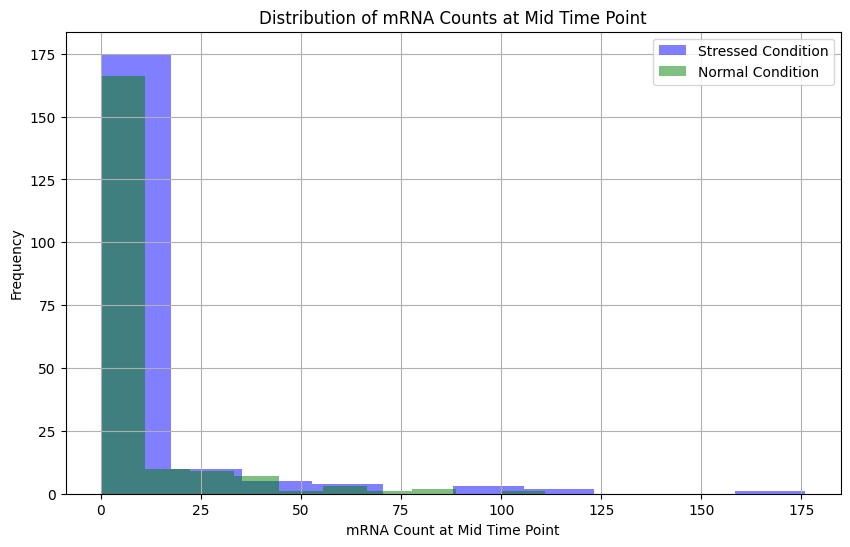

In [ ]:
# Plots
plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories)